# Logistic Regression

Load the titanic.csv dataset into this notebook as a pandas dataframe.

In [2]:
import pandas as pd

df = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_Titanic_dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Model Evaluation

👇 We want to predict whether a passenger survived (Survived) the Titanic disaster, according to the following features:

- The class in which she/he was travelling (Pclass)
- The number of siblings/spouses he had onboard (SibSp)
- The number of parents/children he had onboard (Parch)
- The fare he paid for the ticket (Fare)

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Create the feature set
X = df[['Pclass','SibSp','Parch','Fare']]
y = df['Survived']

# Instanciate model
model = LogisticRegression(max_iter=1000)

# 5-Fold Cross validate model
cv_results = cross_validate(model, X, y, cv=5)

# Mean of accuracies
accuracy = cv_results['test_score'].mean()

accuracy

np.float64(0.6835791852363318)

## In-depth Diagnosis
We want to investigate its performance in more depth. Is the model overfitting? Underfitting? How many learning examples does it need to learn optimally on the given features?

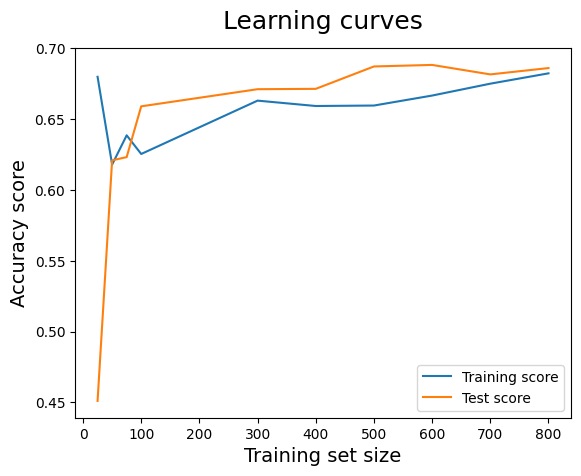

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(max_iter=1000),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,300,400,500,600,700,800], 
                                                              cv = 20)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend()

👉 The curves should have converged:

The model is not overfitting (no variance): it generalizes well.

👉 The test score stops increasing around 500 training observations:

The model does not need more than 500 training observations to perform optimally on the given features.


## Reduced training size

👇 Evaluate a model on the training size suggested by the curves.

In [6]:
# Create the reduced feature set and target
df_reduced = df.sample(n=500, random_state=1)
X_reduced = df_reduced[['Pclass','SibSp','Parch','Fare']]
y_reduced = df_reduced['Survived']

# 5-Fold Cross validate model
cv_results = cross_validate(LogisticRegression(max_iter=1000), X_reduced, y_reduced, cv=5)

# Mean of accuracies
reduced_training_accuracy = cv_results['test_score'].mean()

reduced_training_accuracy

np.float64(0.682)

## Prediction

In [7]:
# Import the model
from sklearn.linear_model import LogisticRegression

# Instanciate the model
log_model = LogisticRegression(max_iter=1000)

# Train the model on the training data
log_model.fit(np.array(X_reduced), y_reduced)

# Use the trained model to predict
prediction = log_model.predict([[1,0,0,15]])[0]

prediction

np.int64(1)

In [9]:
# Access probability of class 1 in model attributes
probability = log_model.predict_proba([[1,0,0,15]])[0][1]
probability

np.float64(0.6216473629532274)

## Model Calibration
Can we trust the predicted probabilities? 🤔

❗️ Accuracy only evaluate your model performance based on the predicted classes 0s and 1s (obtained via.predict())

❗️ High accuracy does not necessarily mean that predicted probabilities are "calibrated" (obtained via .predict_probas())

📚 [Probability Calibration](https://axk51013.medium.com/%E6%A8%A1%E5%9E%8B%E4%BF%A1%E5%BF%83%E7%9A%84%E6%9C%AC%E8%B3%AA-probability-calibration-cbc680a44efa)


### CalibrationDisplay

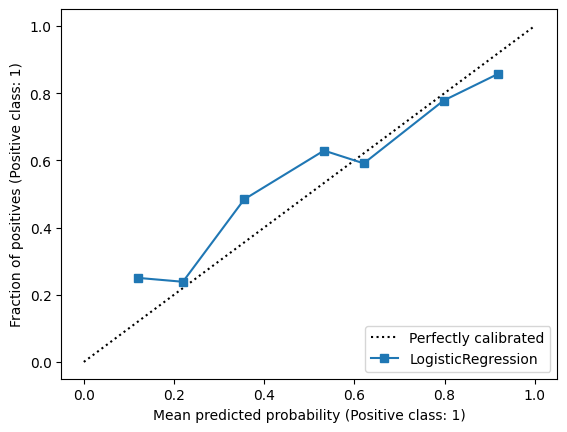

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.5, random_state=1)

# Fit a model on the train set
# $DELETE_BEGIN
model = LogisticRegression().fit(X_train, y_train)
# $DELETE_END

# Print calibration curve on the test set
# $DELETE_BEGIN
disp = CalibrationDisplay.from_estimator(model, X_test, y_test, n_bins=7)
# $DELETE_END

👉 If for the previous prediction you got a probability of around 0.65 then, if the model was well-calibrated, 65% of the cases that model assigns a probability of 0.65 would actually have the class 1 ("Survived" in our case).

But from our calibration curves we can notice, that when the model predicts 0.65, there's actually less (below the curve) real fraction of cases with class 1.

### CalibratedClassifierCV

In [12]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(estimator=model)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(estimator=LogisticRegression())

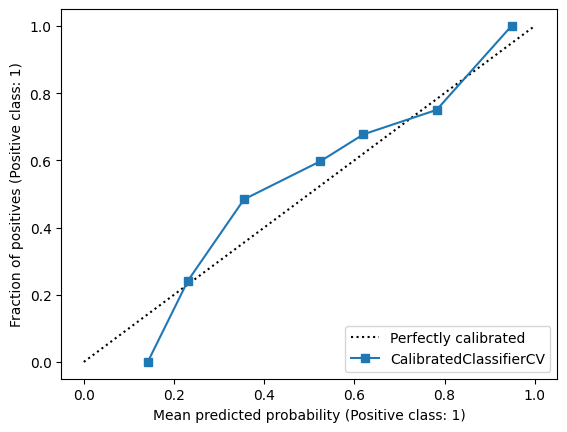

In [13]:
disp = CalibrationDisplay.from_estimator(calibrated_model, X_test, y_test, n_bins=7)

In [14]:
calibrated_model.predict_proba([[1,0,0,15]])[0][1]

np.float64(0.5102756520553418)

👉  Our previous model tended to slightly overestimate probabilities around the middle range (for example, there were actually less than 65% of class 1 cases when model was predicting probability of 0.65).

👉  Calibration seems to have made our model slightly underestimate those probabilities 🙃; for example, when the model predicts a probability of 0.5 the real fraction of cases with class 1 is more than that.

📚 [What is calibration of the classifier and when to use it?](https://medium.com/@rdhawan201455/what-is-calibration-of-the-classifier-and-when-to-use-it-6a00936fb826)
